In [3]:
# Importing the needed libraries:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import math
import statistics

# For debug purposes only. To be removed.
import time

In [22]:
# Meixner process parameters. No subordinator.
a = 0.3977
b = -1.4940
d = 0.3462

r = 1.9/100 
q = 1.2/100

S0 = 1124.47

In [5]:
# time_points is the list of points in which we simulate the process at
def BM_path(time_points):
    trajectory = [0]
    for t in range(1, len(time_points)):
        realization = trajectory[-1]+np.sqrt(time_points[t]-time_points[t-1])*np.random.normal()
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [6]:
def poisson_path(intensity, time_points):
    i = intensity*(time_points[1]-time_points[0])
    trajectory = [0]
    for t in time_points:
        trajectory.append(trajectory[-1]+np.random.poisson(i))
    return dict(zip(time_points, trajectory))

In [7]:
# this is defined so that we do not repeatedly compute the integrals inside the meixner trajectory function
def meix_optimization(k, alpha):
    # density function of the meixner measure
    def meixner_meas(x):
        return d*(np.exp(b*x/a)/(x*np.sinh(np.pi*x/a)))
    
    # partitioning via inverse linear boundaries method
    def ilb_partition(k, alpha):
        lhs = [-alpha/i for i in range(1,k+2)]
        rhs = [-x for x in reversed(lhs)]
        return lhs, rhs
        
    # we could experiment with these values
    left_part, right_part = ilb_partition(k,alpha)
    partition = left_part + right_part
    
    # intensities for our Poisson processes
    left_lambdas = [integrate.quad(meixner_meas, left_part[i], left_part[i+1])[0] for i in range(len(left_part)-1)]
    right_lambdas = [integrate.quad(meixner_meas, right_part[i], right_part[i+1])[0] for i in range(len(right_part)-1)]
    lambdas = left_lambdas + right_lambdas
    
    # will be used later on to compute the c's
    x_sqrd = lambda x : x**2*meixner_meas(x) if x!=0 else 0

    # epsilon must be > 0
    def sigma_sqrd(epsilon):
        return integrate.quad(x_sqrd, -epsilon, epsilon)[0]

    # variance of the poisson processes
    c_left = [-np.sqrt(integrate.quad(x_sqrd, left_part[i], left_part[i+1])[0]/left_lambdas[i]) for i in range(len(left_part)-1)]
    c_right = [np.sqrt(integrate.quad(x_sqrd, right_part[i], right_part[i+1])[0]/right_lambdas[i]) for i in range(len(right_part)-1)]
    c = c_left + c_right
    
    # drift
    gamma_ = a*d*np.tan(b/2)-2*d*(integrate.quad(lambda x: np.sinh(b*x/a)/np.sinh(np.pi*x/a), 1, 20)[0])
    
    # used to incorporate the small jumps
    sigma_ = np.sqrt(sigma_sqrd(right_part[0]))
    
    return partition, lambdas, c, gamma_, sigma_

indicator = lambda cond : 1 if cond else 0

In [8]:
partition, lambdas, c, gamma_, sigma_ = meix_optimization(100, 1)

In [9]:
def meixner_trajectory(time_points):
    bm = BM_path(time_points)
    N = [poisson_path(l, time_points) for l in lambdas]
    
    trajectory = []
    for t in time_points:
        s = [c[j]*( N[j][t] - lambdas[j]*t*indicator(np.abs(c[j]) < 1) ) for j in range(len(c))]
        realization = gamma_*t + sigma_*bm[t] + sum(s)
        #realization = sigma_*bm[t] + sum(s)
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

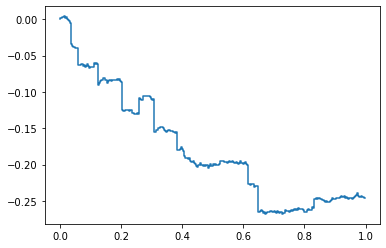

In [10]:
meix = meixner_trajectory([i/300 for i in range(300)])
plt.step(list(meix.keys()), list(meix.values()))

# The $S_t$ process

In [25]:
def meixner_martingale(T):
    m_new = r-q-2*d*(np.log(np.cos(b/2))-np.log(np.cos((a+b)/2)))
    path = meixner_trajectory([T*i/200 for i in range(201)])
    t = np.array(list(path.keys()))
    x_t = np.array(list(path.values()))
    return dict(zip(t,S0*np.exp(m_new*t+x_t)))

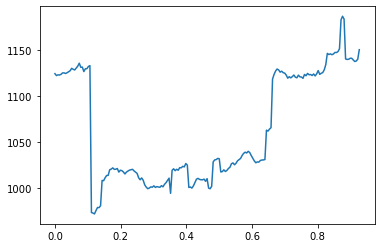

In [56]:
path = meixner_martingale(338/365)
plt.plot(path.keys(), path.values())

# Monte Carlo Simulations

In [27]:
def payoff_eur_call(ST, K):
    return max(ST-K,0)

In [43]:
def mc_ec_meixner(T, K, sims):
    t=[]
    for i in range(sims):
        final_value = list(meixner_martingale(T).values())[-1]
        t.append(payoff_eur_call(final_value, K))
    return np.exp(-r*T)*np.mean(t)

In [46]:
%%time
resl1 = mc_ec_meixner(338/365, 1150, 1000)

CPU times: user 1min 26s, sys: 178 ms, total: 1min 26s
Wall time: 1min 26s


In [47]:
resl1

65.60671787016639

In [ ]:
%%time
# this is slow. Run at your own peril

K_list = [1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325]
prices_list = [146.50,96.20,81.7,68.30,56.6,46.1,36.9,29.3,22.5,17.2,12.8]

mc_predictions = []
for k in K_list:
    mc_predictions.append(mc_ec_meixner(1124.47, 1.9/100, 1.2/100, 338/365, k, 1000))
the_reveal = list(zip(mc_predictions, prices_list))

In [ ]:
arpe = 1/len(the_reveal)*sum([abs(market - model)/market for model, market in the_reveal])

In [ ]:
print(arpe)

In [ ]:
the_reveal

In [48]:
def payoff_DIBC(trajectory, T, H, K):
    vals = trajectory
    min_realization = min(vals)
    ST = vals[-1]
    return payoff_eur_call(ST, K)*(min_realization <= H)

In [52]:
def mc_DIBC_meixner(T, H, K, sims):
    payoffs = []
    for i in range(sims):
        path = meixner_martingale(T) 
        payoffs.append(payoff_DIBC(list(path.values()), T, H, K))
    return np.exp(-r*T)*np.mean(payoffs)

In [53]:
barrier_mc = mc_DIBC_meixner(1, 1124.47*0.95, 1124.47, 2000)

In [54]:
barrier_mc

8.935500150880378